In [ ]:
%pip install qiskit 
%pip install qiskit-aer 
%pip install pylatexenc 
%pip install qiskit-ibm-runtime 
%pip install qiskit-ibm-provider 

# Implementing Grover's algorithm for the case of 2 qubits with the winning state of |w⟩=|10110⟩

In [ ]:
#initialization
import matplotlib.pyplot as plt
import numpy as np

# importing Qiskit
from qiskit import QuantumCircuit, transpile, ClassicalRegister, QuantumRegister
from qiskit_aer import AerSimulator
from qiskit.visualization import plot_state_city

# import basic plot tools
from qiskit.visualization import plot_histogram


In [74]:
def oracle(qc: QuantumCircuit):
    qc.mcx([0, 1, 2, 3, 4], 5, ctrl_state='10110')

In [75]:
def diffuser(qc: QuantumCircuit):
    for qubit in range(5):
        qc.h(qubit)
    
    for qubit in range(5):
        qc.x(qubit)
    
    qc.h(4)
    qc.mcx([0, 1, 2, 3], 4)
    qc.h(4)
    
    for qubit in range(5):
        qc.x(qubit)
    
    for qubit in range(5):
        qc.h(qubit)

# Grover Algorithm

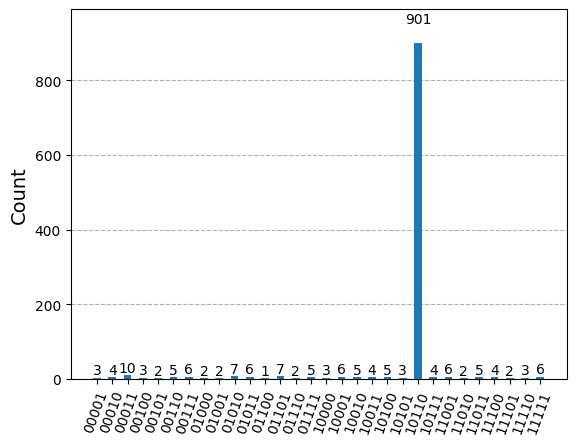

In [76]:
iteration_count = int(np.sqrt(2**5))

qc=QuantumCircuit(6, 5)

qc.x(5)

for i in range(6):
    qc.h(i)

for i in range(iteration_count):
    oracle(qc)
    diffuser(qc)

qc.measure(range(5), range(5))

qc.save_statevector()

aer_sim = AerSimulator(method='statevector')
qobj = transpile(qc, aer_sim)
result = aer_sim.run(qobj).result()

counts = result.get_counts()
plot_histogram(counts)


In [ ]:
state_vector = result.get_statevector()
real_parts = state_vector.data.real
state_amplitudes = real_parts[:32]


num_states = len(state_amplitudes)
binary_labels = [f"{i:05b}" for i in range(num_states)] 


plt.figure(figsize=(12, 6))
plt.bar(binary_labels, state_amplitudes, color='blue')


plt.xlabel('States (Binary)')
plt.ylabel('Amplitude')
plt.title('Amplitudes of Quantum States')
plt.xticks(rotation=90) 
plt.grid(axis='y', linestyle='--', alpha=0.7)


plt.tight_layout() 
plt.show()

In [23]:
ctrl_state = "10110"

bit_count = ctrl_state.__len__()

test_circuit = QuantumCircuit(bit_count)

for index, char in enumerate(ctrl_state):
    if (char=="0"):
        test_circuit.x(index)
for i in range(bit_count):
    test_circuit.h(i)    
    
for i in range(bit_count):
    for j in range(bit_count)[i:]:
        if (i!=j):
            test_circuit.cz(i, j)

for i in range(bit_count):
    test_circuit.h(i)  

for index, char in enumerate(ctrl_state):
    if (char=="0"):
        test_circuit.x(index)
test_circuit.draw()


┌───┐                    ┌───┐                            
q_0: ┤ H ├──────■──■──■─────■─┤ H ├────────────────────────────
     ├───┤┌───┐ │  │  │     │ └───┘   ┌───┐┌───┐               
q_1: ┤ X ├┤ H ├─■──┼──┼──■──┼───■───■─┤ H ├┤ X ├───────────────
     ├───┤└───┘    │  │  │  │   │   │ └───┘└───┘┌───┐          
q_2: ┤ H ├─────────■──┼──■──┼───┼───┼───■────■──┤ H ├──────────
     ├───┤            │     │   │   │   │    │  └───┘┌───┐     
q_3: ┤ H ├────────────■─────┼───■───┼───■────┼────■──┤ H ├─────
     ├───┤┌───┐             │       │        │    │  ├───┤┌───┐
q_4: ┤ X ├┤ H ├─────────────■───────■────────■────■──┤ H ├┤ X ├
     └───┘└───┘                                      └───┘└───┘

In [ ]:
test_circuit.save_statevector()


aer_sim = AerSimulator(method='statevector') # Use a noise-free simulator
qobj = transpile(test_circuit, aer_sim)
result = aer_sim.run(qobj, shots = 4096).result()
print(result.get_statevector())

C:\Users\mathi\AppData\Local\Temp\ipykernel_15280\3432701146.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(affected_bitstrings, rotation=90)
C:\Users\mathi\AppData\Local\Temp\ipykernel_15280\3432701146.py:36: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  a.set_xticklabels(affected_bitstrings, rotation=90)


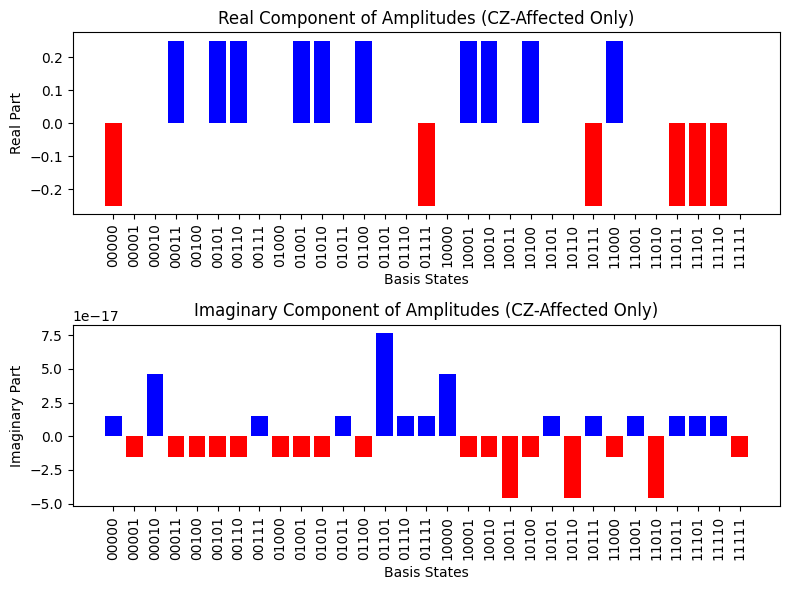

In [25]:
import matplotlib.pyplot as plt
import numpy as np
from qiskit.quantum_info import Statevector

# Get statevector data
statevector = result.get_statevector()

# Extract real parts
real_parts = statevector.data.real
imag_parts = statevector.data.imag

# Generate bitstrings for the x-axis
bitstrings = [format(i, f'0{bit_count}b') for i in range(2**bit_count)]

# Identify affected states (sign flip due to CZ)
affected_indices = [i for i in range(len(real_parts)) if real_parts[i] < 0 or imag_parts[i] < 0]
affected_bitstrings = [bitstrings[i] for i in affected_indices]
affected_real_parts = [real_parts[i] for i in affected_indices]
affected_imag_parts = [imag_parts[i] for i in affected_indices]

# Plot real and imaginary parts (only affected states)
fig, ax = plt.subplots(2, 1, figsize=(8, 6))

# Real part
ax[0].bar(affected_bitstrings, affected_real_parts, color=['red' if x < 0 else 'blue' for x in affected_real_parts])
ax[0].set_ylabel('Real Part')
ax[0].set_title('Real Component of Amplitudes (CZ-Affected Only)')

# Imaginary part
ax[1].bar(affected_bitstrings, affected_imag_parts, color=['red' if x < 0 else 'blue' for x in affected_imag_parts])
ax[1].set_ylabel('Imaginary Part')
ax[1].set_title('Imaginary Component of Amplitudes (CZ-Affected Only)')

# Formatting
for a in ax:
    a.set_xticklabels(affected_bitstrings, rotation=90)
    a.set_xlabel('Basis States')

plt.tight_layout()
plt.show()


## Create the circuit and initalize the qubits

In [ ]:
grover_circuit = QuantumCircuit(n)

def initialize_s(qc, qubits):
    """Apply a H-gate to 'qubits' in qc"""
    for q in qubits:
        qc.h(q)
    return qc
grover_circuit = initialize_s(grover_circuit, [0,1])
grover_circuit.draw(output='mpl', style="clifford")

## Apply the Oracle (phase inversion) for |w⟩=|11⟩ (Controlled-Z gate in this case)

In [ ]:
grover_circuit.barrier()
grover_circuit.cz(0,1) # Oracle
grover_circuit.draw(output='mpl')

## Apply the diffuser (inversion about the mean)

In [ ]:
# Diffusion operator (U_s)
grover_circuit.barrier()
grover_circuit.h([0,1])
grover_circuit.z([0,1])
grover_circuit.cz(0,1)
grover_circuit.h([0,1])
grover_circuit.barrier()

grover_circuit.draw(output='mpl')

## Apply measurement

In [ ]:
grover_circuit.measure_all()
grover_circuit.draw(output='mpl')

## Run the circuit on a noise-free simulator

---



```
# This is formatted as code
```

simulator

In [30]:
aer_sim = sim = AerSimulator(method='statevector') # Use a noise-free simulator
qobj = transpile(grover_circuit, aer_sim)
result = aer_sim.run(qobj).result()
counts = result.get_counts()
plot_histogram(counts)

QiskitError: 'No counts for experiment "0"'

## Run the circuit on IBM quantum (IBM Q)

### Preparation for accessing IBM Q: store your IBM Q credential on your local computer
Step 1: Create an IBM Quantum account or log in to your existing account (visit the [IBM Quantum login page](https://quantum-computing.ibm.com/login)). <br>
Step 2: Copy your API token (or optionally regenerate one) from your [IBM Quantum account page](https://quantum-computing.ibm.com/account)
<br>
Step 3: Run the funciton IBMProvider.save_account(token='MY_API_TOKEN') below (replace API_Token with your copied API toke).
<br>
For more information: https://pypi.org/project/qiskit-ibm-provider/

In [ ]:
#!pip install qiskit_ibm_provider

## Run the circuit on a simulator simulating a quantum device (QPU)
https://docs.quantum.ibm.com/guides/local-testing-mode


In [ ]:
# Run our circuit on the backend.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# Replace 'YOUR_API_TOKEN' with your actual IBM Quantum API token
token='MY_API_TOKEN'
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True
)

service = QiskitRuntimeService()

In [ ]:
# Specify the backend to use
backend = service.backend("ibm_sherbrooke")
sim_backend = AerSimulator.from_backend(backend)

qobj = transpile(grover_circuit, sim_backend)
result = sim_backend.run(qobj, shots = 4096).result()
counts = result.get_counts()
plot_histogram(counts)

## Run the circuit on a real quantum device (QPU)

In [ ]:
# Run our circuit on the backend.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler

# Replace 'YOUR_API_TOKEN' with your actual IBM Quantum API token
token='MY_API_TOKEN'
QiskitRuntimeService.save_account(
  token=token,
  channel="ibm_quantum", # `channel` distinguishes between different account types
  overwrite=True
)

service = QiskitRuntimeService()

In [ ]:
# choose the least busy QPU
real_backend = service.least_busy(simulator=False, operational=True)
print(real_backend)

In [ ]:
# Run the circuit on the QPU

qobj = transpile(grover_circuit, real_backend)

# Define Sampler: https://docs.quantum.ibm.com/guides/get-started-with-primitives
sampler = Sampler(mode=real_backend)

# Run calculation
job = sampler.run([qobj])

result = job.result()

In [ ]:
# Print and visualize the results (counts)
counts = result[0].data.meas.get_counts()
print(counts)
plot_histogram(counts) # Display the results